<a href="https://colab.research.google.com/github/Cbilinski/DataSciencePracticeCollabs/blob/main/Copy_of_ad_gd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autodiff and Gradient Descent in Pure Python

After Jackson's lecture on backpropagation, let's try to implement a minimal version of autodiff and gradient descent in pure python.
The functionality and speed of the code will not be enough for real deep learning, but it's a good way to help us understand these important ingredients.

## Autodiff with Dual Numbers

There are many ways to implement autodiff (and backpropagation).
For the purpose for this quick demo, we will use the dual number formulation.

The idea is, for each variable $x$ in a function $f$, we always keep a copy of its derivative with us.
The variable $x$ and its derivative $x'$ together form a "dual number" $(x,x')$ that follows some algebraic rules:
* Linearity: $(a,a') + (b,b') = (a+b, a'+b')$;
* Product Rule: $(a,a') (b,b') = (ab, a'b + ab')$.
Using these simple algebraic properties, we are ready to create our own autodiff!

The idea is pretty simple.
Consider a algebraic function $f(x)$ and evaluating it at $x_0$, instead of passing `x0` to it, we pass a dual number `(x0,1)` to `f`.
The above algebric rule will automatically propagate both the variable and its derivative along the function, making the python function returns both the value $f(x)$ and derivative $f'(x)$.

In order to handle, e.g., multiplication, with normal python numbers, we first create helper functions that select the value and derivative from a dual number.

In [1]:
def V(x):
    """Select the value from a dual number.

    Work for both python built-in numbers (often used in function) and dual numbers.
    """
    if isinstance(x, Dual):
        return x[0]
    else:
        return x

def D(x):
    """Select the derivative from a dual number.

    Work for both python built-in numbers (often used in function) and dual numbers.
    """
    if isinstance(x, Dual):
        return x[1]
    else:
        return 0

We then define the `Dual` class and override algebraic operators.
To make unpacking the value and derivative easy, we implement `Dual` as a `tuple`.

In [2]:
2+2

4

In [ ]:
class Dual(tuple):
    """Dual number for implementing autodiff in pure python"""

    def __new__(self, v, d=1): # tuple is immutable so we cannot use __init__()
        return tuple.__new__(Dual, (v, d))

    def __add__(self, r):
        return Dual(
            V(self) + V(r),
            D(self) + D(r),
        )

    def __radd__(self, l):
        return Dual(
            V(l) + V(self),
            D(l) + D(self),
        )

    def __mul__(self, r):
        return Dual(
            V(self) * V(r),
            D(self) * V(r) + V(self) * D(r),
        )

    def __rmul__(self, l):
        return Dual(
            V(l) * V(self),
            V(l) * D(self) + D(l) * V(self),
        )

    def __sub__(self, r):
        return Dual(
            V(self) - V(r),
            D(self) - D(r),
        )

    def __sub__(self, l):
        return Dual(
            V(l) - V(self),
            D(l) - D(self),
        )

    def __truediv__(self, r):
        return Dual(
            V(self) / V(r),
            D(self) / V(r) - V(self) * D(r) / (V(r) * V(r)),
        )

    def __rtruediv__(self, l):
        return Dual(
            V(l) / V(self),
            D(l) / V(self) - V(l) * D(self) / (V(self) * V(self))
        )
    def __pow__(self, r): # assume r is constant
        return Dual(
            V(self) ** r,
            r * V(self) ** (r-1),
        )


That's it!
We've implemented (a limited version of) autodiff in pure python!
Let's test it out.
We will plot both a function $f(x)$ and its derivative $f'(x)$ as tangent lines.

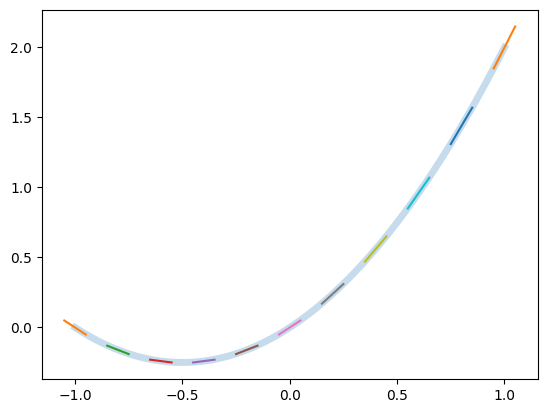

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def f(x):
    return x + x*x

X     = np.linspace(-1,1,num=101)
Y, dY = f(Dual(X))

plt.plot(X, Y, lw=5, alpha=0.25)
for (x, y, dy) in list(zip(X, Y, dY))[::10]:
    plt.plot(
        [x-0.05,    x+0.05],
        [y-0.05*dy, y+0.05*dy],
    )

## Exercise/hack 1

**1a)** In the above cell, redefine function $f$ as
\begin{align}
    f(x) = 2x + x^2
\end{align}
and try our autodiff.

<ipython-input-41-3479e3d74528>:51: RuntimeWarning: divide by zero encountered in divide
  V(l) / V(self),
<ipython-input-41-3479e3d74528>:52: RuntimeWarning: invalid value encountered in divide
  D(l) / V(self) - V(l) * D(self) / (V(self) * V(self))
<ipython-input-41-3479e3d74528>:52: RuntimeWarning: divide by zero encountered in divide
  D(l) / V(self) - V(l) * D(self) / (V(self) * V(self))


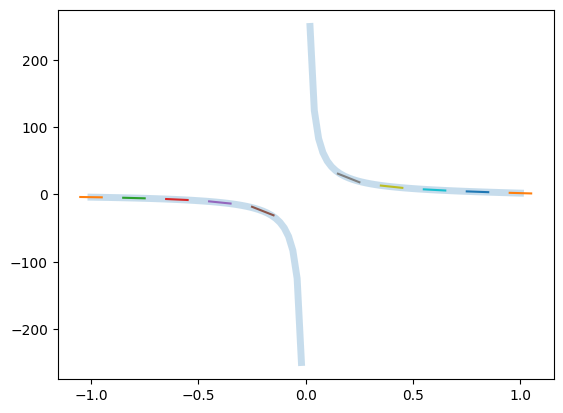

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def f(x):
    return 2*x + x*x -5/x

X     = np.linspace(-1,1,num=101)
Y, dY = f(Dual(X))

plt.plot(X, Y, lw=5, alpha=0.25)
for (x, y, dy) in list(zip(X, Y, dY))[::10]:
    plt.plot(
        [x-0.05,    x+0.05],
        [y-0.05*dy, y+0.05*dy],
    )

Ooops... it is not going to work.

This is because when python sees `2 * x`, it uses the `__mul__()` function in class/type `int`, which doesn't understand Dual number.

In order to make `[int] * [Dual]` work, implement the `__rmul__()` method in class `Dual` and check if autodiff work with this new function.

**1b)** By the same token, implement `__radd__()` so our autodiff works for
\begin{align}
    f(x) = 3 + 2x + x^2.
\end{align}

**1c)** Take a look at the list of [magic methods](https://docs.python.org/3/reference/datamodel.html#emulating-numeric-types), implement some of them so our autodiff works for more algebraic functions.

## Chain rule

The dual number formulation makes implementing autodiff in python super simple.
However, our implementation so far only works for basic algebraic equations.
To generalize our autodiff to more complicated equations, we need to use the chain rule.
The idea is very similar, we define our own function where the "value" slot we return the function itself, but the "derivative" slot we return the derivative of the function using chain rule.

In [ ]:
def sin(x):
    return Dual(
        np.sin(V(x)),
        np.cos(V(x)) * D(x), # chain rule [f(g)]' = f'(g) g'
    )

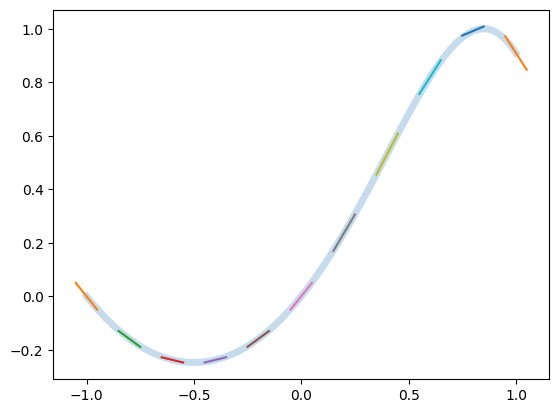

In [ ]:
def f(x):
    return sin(x + x*x)

Y, dY = f(Dual(X))

plt.plot(X, Y, lw=5, alpha=0.25)
for (x, y, dy) in list(zip(X, Y, dY))[::10]:
    plt.plot(
        [x-0.05,    x+0.05],
        [y-0.05*dy, y+0.05*dy],
    )

## Exercise/hack 2

**2a)** In the above cells, define your own autodiff-able `cos` function, redefine function $f$ as
\begin{align}
    f(x) = \cos(2x + x^2),
\end{align}
and try our autodiff.

**2b)** By the same token, implement `__pow__()` in class `Dual` so our autodiff works when we write `x*x` as `x**2`.

In [ ]:
def cos(x):
    return Dual(
        np.cos(V(x)),
        np.sin(V(x)) * -D(x), # chain rule [f(g)]' = f'(g) g'
    )

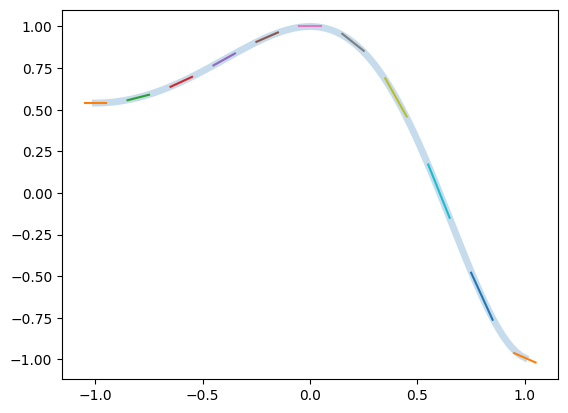

In [ ]:
def f(x):
    return cos(2*x + x**2)

Y, dY = f(Dual(X))

plt.plot(X, Y, lw=5, alpha=0.25)
for (x, y, dy) in list(zip(X, Y, dY))[::10]:
    plt.plot(
        [x-0.05,    x+0.05],
        [y-0.05*dy, y+0.05*dy],
    )

## Gradient Descent

We are now ready to implement our own very simple version of gradient descent.
Using the same function $f(x) = \sin(x + x^2)$, we are interesting in finding its minimum at $x = 0.5$.

0 : 0.0 0
10 : -0.24361146294283537 -0.4374521419141116
20 : -0.24730737002105516 -0.4900156606240282
30 : -0.24740035086858225 -0.4980701918957002
40 : -0.247403770091448 -0.4995581489257089
50 : -0.2474039458485275 -0.49988237293222876
60 : -0.24740395801143336 -0.4999641813718482
70 : -0.24740395910798565 -0.4999877020761088
80 : -0.24740395923311365 -0.4999952993395743
90 : -0.2474039592507324 -0.4999980220870708
100 : -0.2474039592537257 -0.4999990929213049


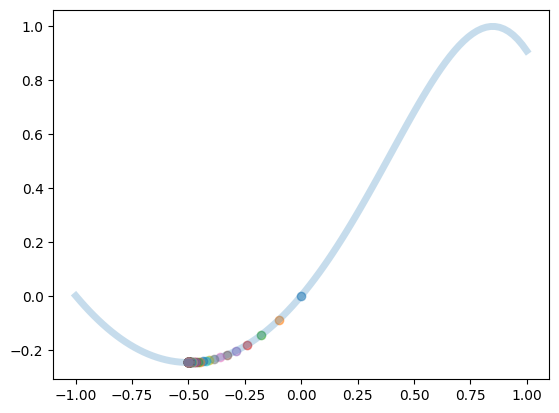

In [ ]:


def f(x):
    return sin(x + x*x)

Y, dY = f(Dual(X))


plt.plot(X, Y, lw=5, alpha=0.25)

x    = 0    # initial value
rate = 0.1  # learning rate
nmax = 1000 # maximum number of iteration

for i in range(nmax):
    y, dy = f(Dual(x))

    if abs(dy) < 1e-6:
        break
    elif i % 10 == 0:
        print(i, ':', y, x)

    plt.scatter([x], [y], alpha=0.5)
    x = x - rate * dy
    rate = rate * 0.99

#plt.xlim(-0.51, -0.49)
#plt.ylim(-0.247425,  -0.2473)

## Exercise/hack 3

**3a)** In the above cell, print different variables to help you understand how gradient descent works.

**3b)** In the above cell, try adjust the learning rate and see how it improves or breaks gradient descent.

**3c)** Are there other strategies?  How about we adjust the learning rate according to the gradient?

## Partial Derivatives

Our autodiff is capable to compute partial derivative.

For a standard multi-variable function $f(x_1, x_2, ..., x_n)$, the partial derivative with respective to the variable $x_i$ can be obtained by `f(x1, x2, ..., Dual(xi), ..., xn)`.
Let's test it out.

In [ ]:
def f(x, y):
    return 5 * x * x + 4 * x * y + 3 * y * y + 2 * x + y

print(f(Dual(1), 1)) # 10x + 4y      + 2 -> 16
print(f(1, Dual(1))) #       4x + 6y + 1 -> 11

(15, 16)
(15, 11)


Note that the value of the function is evaluated twice.
This is ok given the simplicity of our Dual number implementation.

However, for more complicated functions with many parameters, it would be more convenient to pass a list of parameters.
It is also straightforward to implement.

In [ ]:
def f(X):
    return 5 * X[0] * X[0] + 4 * X[0] * X[1] + 3 * X[1] * X[1] + 2 * X[0] + X[1]

def partial(f, i):
    def g(X): # closure on `f` and `i`
        return f([
            Dual(x) if j == i else x
            for j, x in enumerate(X)
        ])
    return g

print(partial(f, 0)((1,1))) # 10x + 4y      + 2 -> 16
print(partial(f, 1)((1,1))) #       4x + 6y + 1 -> 11

(15, 16)
(15, 11)


## Multi-variable Gradient Descent

Apply gradient descent to find the minimum of a multi-variable function.

In [ ]:
X = np.linspace(-1, 1, num=101)
Y = np.linspace(-1, 1, num=101)
XX, YY = np.meshgrid(X, Y)
ZZ = f([XX, YY])

   0: 0.000000, 0.000000, 0.000000
  10: -0.120836, -0.054490, -0.187910
  20: -0.156648, -0.062524, -0.202222
  30: -0.168838, -0.060214, -0.203816
  40: -0.173967, -0.056510, -0.204218
  50: -0.176656, -0.053372, -0.204388
  60: -0.178298, -0.051035, -0.204469
  70: -0.179383, -0.049365, -0.204508
  80: -0.180123, -0.048189, -0.204527
  90: -0.180636, -0.047365, -0.204537
 100: -0.180993, -0.046789, -0.204541
 110: -0.181242, -0.046386, -0.204543
 120: -0.181416, -0.046105, -0.204544
 130: -0.181537, -0.045909, -0.204545
 140: -0.181622, -0.045772, -0.204545
 150: -0.181681, -0.045676, -0.204545
 160: -0.181723, -0.045609, -0.204545
 170: -0.181751, -0.045563, -0.204545
 180: -0.181772, -0.045530, -0.204545
 190: -0.181786, -0.045507, -0.204545
 200: -0.181795, -0.045491, -0.204545
 210: -0.181802, -0.045480, -0.204545
 220: -0.181807, -0.045472, -0.204545
 230: -0.181810, -0.045467, -0.204545
 240: -0.181813, -0.045463, -0.204545
 250: -0.181814, -0.045461, -0.204545
 260: -0.181816

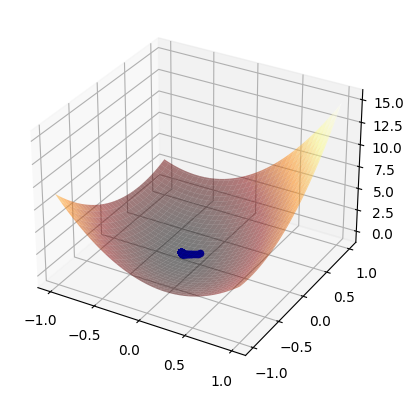

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(XX, YY, ZZ, cmap='afmhot', alpha=0.5)

X    = [0, 0] # initial value
rate =  0.01  # learning rate
nmax =  1000  # maximum number of iteration

for i in range(nmax):
    z, z0 = partial(f,0)(X)
    z, z1 = partial(f,1)(X)

    if (z0*z0 + z1*z1)**0.5 < 1e-6:
        break
    elif i % 10 == 0:
        print(f'{i:4d}: {X[0]:.6f}, {X[1]:.6f}, {z:.6f}')
    ax.scatter([X[0]], [X[1]], [z], color='b')

    X[0] = X[0] - rate * z0
    X[1] = X[1] - rate * z1

## Exercise/hack 4

**4a)** We have already implemented a partial derivitaive function.
Based on it, implement a gradient function `grad()` similar to `partial()` that works for functions with different input dimensions of `X`.

**4b)** Implement a `norm()` function to compute the norm of any vector, including the gradient.

**4c)** The above gradient descent algorithm is pretty generic.
Update it using the `grad()` function so it works with function with more input dimensions of `X`.

**4d)** Test your implementation and minimize a high-dimensional function.

Hint: see the curve fitting section below.

## Curve Fitting

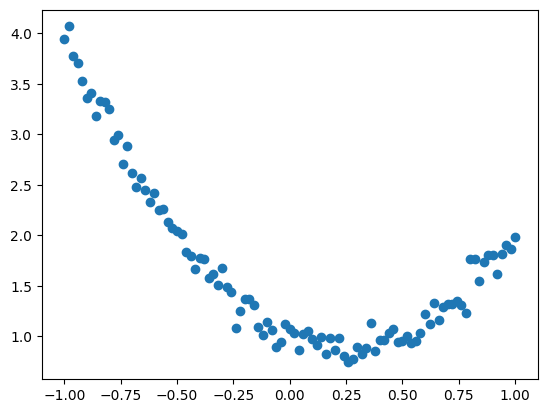

In [ ]:
from random import gauss

X = [i * 0.02 - 1 for i in range(101)]
Y = [1 - x + 2 * x**2 + gauss(0, 0.1) for x in X]

plt.scatter(X, Y)

In [ ]:
def poly(A, x):
    s = 0
    for i, a in enumerate(A):
        s += a * x**i
    return s

def loss(A):
    s = 0
    for x, y in zip(X, Y):
        chi = poly(A, x) + (-y) # in case __sub__() is not implement in Dual
        s  += chi * chi
    return s * (1/len(X)) # in case __realdiv__() is not implement in Dual

def grad(A):
    return [partial(loss, i)(A)[1] for i in range(len(A))]

def norm(G):
    s = 0
    for g in G:
        s += g * g
    return s**0.5 * (1/len(G))

0 : 3.5636420153487163 [0, 0, 0, 0]
10 : 0.21528802190488405 [1.337204313093834, -0.4516809973865604, 0.7434354393491945, -0.26889578106651124]
20 : 0.11929441186077151 [1.3792923799882302, -0.6245317283809514, 0.9692767733682892, -0.3587470770393965]
30 : 0.08585051614209847 [1.3298814124272627, -0.6942248600722681, 1.1291403824627615, -0.38281427264323786]
40 : 0.06491925092197072 [1.281376808761757, -0.7256292757996712, 1.2621509421207264, -0.3829042690551525]
50 : 0.05024649268624337 [1.239756888403238, -0.7427027028290509, 1.3746720163316677, -0.37444232877763933]
60 : 0.0397099440719488 [1.2044479765134317, -0.7542974385524014, 1.4700070421203435, -0.36311346470381045]
70 : 0.03209809578500955 [1.1745241821309287, -0.7636883346844722, 1.550792446327418, -0.351006752237584]
80 : 0.026583299670346228 [1.149166617596815, -0.7720907221601141, 1.6192496260185243, -0.33888391681622543]
90 : 0.022576798627671934 [1.1276786864851707, -0.7799593049493366, 1.6772599948972815, -0.3270169289

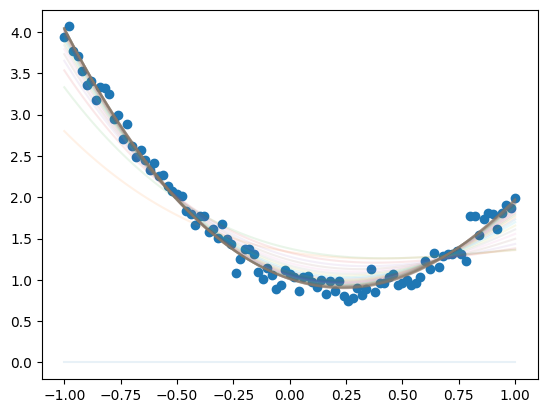

In [ ]:
plt.scatter(X, Y)

A    = [0, 0, 0, 0] # initial value
rate =  0.1         # learning rate
nmax = 1000         # maximum number of iteration

for i in range(nmax):
    l, G = loss(A), grad(A)

    if norm(G) < 1e-3:
        break
    elif i % 10 == 0:
        print(i, ':', l, A)
        plt.plot(X, [poly(A, x) for x in X], alpha=0.1)

    A = [a - rate * g for a, g in zip(A, G)]

## Exercise/hack 5

**5a)** In the above example, change the form of the function and confirm that gradient descent is able to fit the data.

**5b)** Change the number of data points $n$ and degree of the polynomial $p$.
What happends if $p+1 > n$?

## Second derivative

Once `__radd__()`, `__rmul__()`, etc are implemented, our autodiff also works for second derivatives.

In [ ]:
def f(x):
    return 3 * x * x

def df(x):
    return f(Dual(x,1))[1]

def ddf(x):
    return df(Dual(x,1))[1]

print(f(5))
print(df(5))
print(ddf(5))

75
30
6


Please take our survey! It helps us best tailor our future activities to your interests and needs and should take only 5 minutes or so.

https://bit.ly/DeepHackFeedback

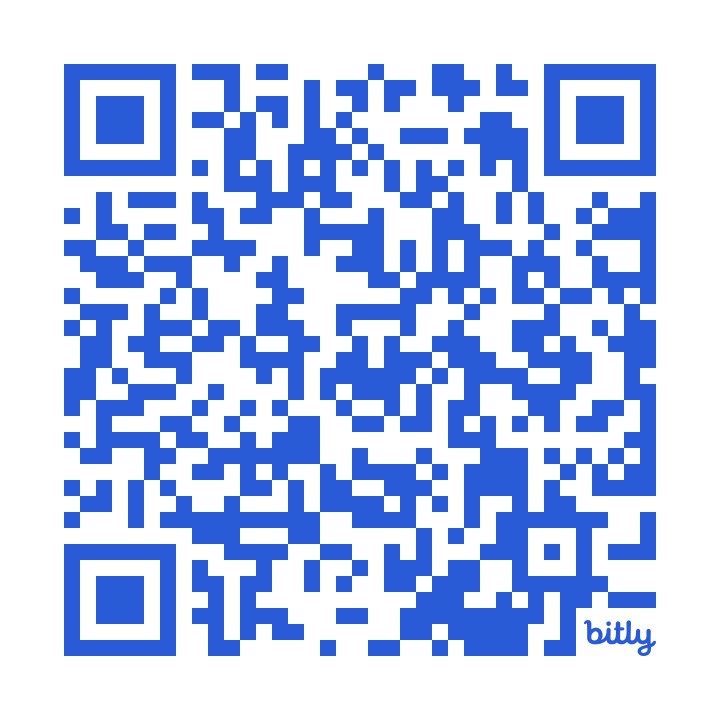